In [1]:
pip install cvxpy yfinance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 98.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.1/127.1 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 104.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.0/356.0 kB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 95.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 kB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.8/183.8 kB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.9/411.9 kB 76.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 109.0 MB/s eta 0:00:00
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np

tickers = ["RELIANCE.NS", "HDFCBANK.NS", "TCS.NS", "INFY.NS"]

prices = yf.download(tickers, start="2019-01-01", end="2024-01-01")["Close"]

returns = np.log(prices / prices.shift(1)).dropna()
returns.to_csv("multi_returns.csv")

print(returns.head())


[*********************100%***********************]  4 of 4 completed
Ticker      HDFCBANK.NS   INFY.NS  RELIANCE.NS    TCS.NS
Date                                                    
2019-01-02    -0.009166  0.005996    -0.013110  0.010716
2019-01-03    -0.007877  0.000150    -0.012414 -0.012215
2019-01-04     0.002672 -0.012179     0.005385 -0.012233
2019-01-07     0.001510  0.015983     0.005537  0.011153
2019-01-08    -0.008358 -0.002460    -0.000090 -0.002295


In [8]:
import pandas as pd
import numpy as np

# Load multi-asset returns
R = pd.read_csv("multi_returns.csv", index_col=0)

# Convert to numpy matrix
Rmat = R.values
T, N = Rmat.shape

print("Scenarios (T):", T)
print("Assets (N):", N)
print("\nFirst 5 rows of return matrix:\n", Rmat[:5])


Scenarios (T): 1234
Assets (N): 4

First 5 rows of return matrix:
 [[-9.16613192e-03  5.99641037e-03 -1.31096149e-02  1.07159613e-02]
 [-7.87688406e-03  1.49513550e-04 -1.24140703e-02 -1.22150319e-02]
 [ 2.67191387e-03 -1.21788411e-02  5.38474461e-03 -1.22326336e-02]
 [ 1.51002064e-03  1.59825929e-02  5.53681552e-03  1.11531981e-02]
 [-8.35769913e-03 -2.45979159e-03 -9.04514909e-05 -2.29455450e-03]]


In [11]:
import cvxpy as cp
import pandas as pd
import numpy as np

# Load scenario returns
R = pd.read_csv("multi_returns.csv", index_col=0)
R = R.values
T, N = R.shape

beta = 0.95

# Decision variables
w = cp.Variable(N)
alpha = cp.Variable()
xi = cp.Variable(T)

# Portfolio losses
loss = -R @ w

# Objective: minimize CVaR
objective = cp.Minimize(alpha + (1/(1-beta)/T) * cp.sum(xi))

# Constraints
constraints = [
    xi >= loss - alpha,
    xi >= 0,
    cp.sum(w) == 1,
    w >= 0
]

# Solve LP
prob = cp.Problem(objective, constraints)
prob.solve()

print("Optimal Weights:")
print(w.value)

print("\nMinimum CVaR:", prob.value)


Optimal Weights:
[0.30287969 0.08210272 0.22858095 0.38643665]

Minimum CVaR: 0.029346326006803578


In [14]:
import numpy as np
import pandas as pd

R = pd.read_csv("multi_returns.csv", index_col=0).values
T, N = R.shape
beta = 0.95

# Optimized weights from Day-3
w_opt = np.array([0.30287969, 0.08210272, 0.22858095, 0.38643665])

# Equal weights
w_eq = np.ones(N) / N

def CVaR(w):
    loss = -R @ w
    VaR = np.quantile(loss, beta)
    return VaR + np.mean(np.maximum(loss - VaR, 0)) / (1 - beta)

print("CVaR (Optimized):", CVaR(w_opt))
print("CVaR (Equal Weights):", CVaR(w_eq))


CVaR (Optimized): 0.029346326309181152
CVaR (Equal Weights): 0.030057010892039368


In [17]:
import numpy as np
import pandas as pd

R = pd.read_csv("multi_returns.csv", index_col=0).values

w_opt = np.array([0.30287969, 0.08210272, 0.22858095, 0.38643665])
w_eq  = np.ones(R.shape[1]) / R.shape[1]

# Portfolio losses
loss_opt = -R @ w_opt
loss_eq  = -R @ w_eq

# Worst 5% scenarios
q = np.quantile(loss_eq, 0.95)
stress_opt = loss_opt[loss_eq >= q].mean()
stress_eq  = loss_eq[loss_eq >= q].mean()

print("Stress Loss Optimized:", stress_opt)
print("Stress Loss Equal Weights:", stress_eq)


Stress Loss Optimized: 0.028984933085807997
Stress Loss Equal Weights: 0.029996756682968855


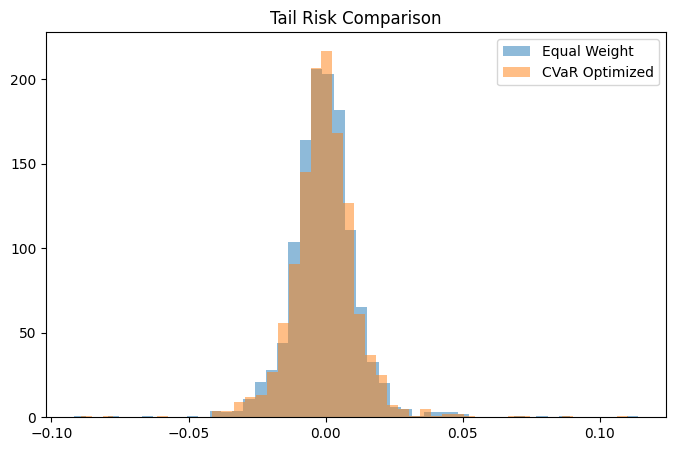

In [23]:
plt.figure(figsize=(8,5))
plt.hist(loss_eq, bins=50, alpha=0.5, label="Equal Weight")
plt.hist(loss_opt, bins=50, alpha=0.5, label="CVaR Optimized")
plt.legend()
plt.title("Tail Risk Comparison")
plt.savefig("cvar_tail_comparison.png", dpi=300, bbox_inches="tight")
plt.show()


In [26]:
import pandas as pd

weights = pd.DataFrame({
    "Asset": ["RELIANCE", "HDFCBANK", "TCS", "INFY"],
    "Optimized Weight": w_opt,
    "Equal Weight": w_eq
})

weights.to_csv("cvar_weights.csv", index=False)
weights


,Asset,Optimized Weight,Equal Weight
0,RELIANCE,0.302880,0.25
1,HDFCBANK,0.082103,0.25
2,TCS,0.228581,0.25
3,INFY,0.386437,0.25


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f4e80ecd-af08-4c5a-8f0a-c8c46b34deb2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>